In [1]:
"""
@file mnist_example.ipynb
@author Ryan Missel

This notebook runs through an example of training a simple 1-layer MNIST classifier
with the meta-prior and visualizing the meta-space following it.
"""
import time
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as func

from tqdm.notebook import tqdm
from scipy.stats import entropy
from sklearn.manifold import TSNE
from IPython.display import clear_output
from torch.distributions import Normal, kl_divergence as kl
from metaprior.metautils import get_act, plot_metaspace_mean, plot_metaspace_var, plot_weight_correlations

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
class MetaPrior(nn.Module):
    def __init__(self, layer_sizes=[1, 100, 1], mean=False, local=False, activation='linear', hyperprior_dim=32, code_dim=2):
        super(MetaPrior, self).__init__()
        self.input_dim = layer_sizes[0]
        self.layer_sizes = layer_sizes
        self.code_dim = code_dim

        self.local = local
        self.mean = mean

        self.acts = [get_act('leaky_relu') if i < len(layer_sizes) - 2 else get_act(activation)
                         for i in range(len(layer_sizes) - 1)]

        self.embedder = nn.Sequential(
            nn.Linear(self.input_dim, 20),
            nn.LeakyReLU(),
            nn.Linear(20, code_dim)
        )

        # Define the initial weight code distribution parameters
        self.code_mu = nn.ParameterList([
            torch.nn.Parameter(
                torch.zeros([lsize, code_dim]), #+ 0.1 * torch.randn([lsize, code_dim], requires_grad=True),
                requires_grad=True)
            for lsize in self.layer_sizes
        ])

        self.code_var = nn.ParameterList([
            torch.nn.Parameter(torch.ones([lsize, code_dim]), # + 0.1 * torch.randn([lsize, code_dim], requires_grad=True),
                               requires_grad=True)
            for lsize in self.layer_sizes
        ])

        self.codes = [
            torch.randn([lsize, code_dim]) for lsize in self.layer_sizes
        ]


        # Define the hyperprior network that generates the distribution parameters of the Weights
        self.hyperprior = nn.Sequential(
            nn.Linear(code_dim * 2, 64),
            nn.LeakyReLU(),
            nn.Linear(64, hyperprior_dim)
        )

        self.mean_net = nn.Linear(hyperprior_dim, 1)
        self.var_net = nn.Linear(hyperprior_dim, 1)

    def generate_weight_codes(self):
        """
        Handles building the weight codes and draw samples from i
        :return:
        """
        # Sample the codes array
        self.codes = [
            self.code_mu[i] + torch.randn_like(self.code_mu[i]) * self.code_var[i]
            for i in range(len(self.layer_sizes))
        ]

        self.weight_codes = []
        self.bias_codes = []

        # Loop between the layers and generate their weight codes by concatenating each units' latent var.
        # Units in the smaller layer need to be duplicated to the size of the next layer in order to perform
        # easy concatenation between their latent variables
        for idx in range(len(self.layer_sizes) - 1):
            temp = self.codes[idx].unsqueeze(1).repeat(1, self.layer_sizes[idx + 1], 1).view([-1, self.code_dim])
            temp2 = self.codes[idx + 1].unsqueeze(0).repeat(self.layer_sizes[idx], 1, 1).view([-1, self.code_dim])
            concated = torch.cat((temp, temp2), dim=1)

            self.weight_codes.append(concated)

            # Generate bias codes (concatenation is just with a zeros vector)
            self.bias_codes.append(torch.cat((self.codes[idx + 1], torch.zeros_like(self.codes[idx + 1])), dim=1))

    def kl_z_term(self):
        """
        KL term related to the distribution parameters of the meta-variables, with prior N(0, 1)
        :return: Sum of the KL values over each latent variable
        """
        mus = torch.cat([cmu.view([-1]) for cmu in self.code_mu])
        var = torch.cat([cvar.view([-1]) for cvar in self.code_var])

        q = Normal(mus, var)
        N = Normal(torch.zeros(len(mus), device=mus.device), torch.ones(len(mus), device=mus.device))
        klz = kl(q, N).sum()
        return klz

    def forward(self, x, perturb=False):
        """
        Handles iterating through each layer, generating the distribution parameters and sampling
        the weights and biases for that layer
        :param x: input x
        :param perturb: whether to perturb one meta-var
        """
        # Generate weight codes given current latent codes
        self.generate_weight_codes()
        local_code = self.embedder(x)

        # Perturb one meta-var to test function draws
        if perturb:
            indice = np.random.randint(0, self.weight_codes[0].shape[0], 1)
            self.weight_codes[0][indice] += torch.hstack((torch.zeros([2]), 2 * torch.randn([2])))

        # Iterate over layers to get output
        for lidx in range(len(self.layer_sizes) - 1):
            # Get latent codes of hyperprior
            if self.local:
                latent_w = self.hyperprior(torch.cat((self.weight_codes[lidx], local_code), dim=1))
                latent_b = self.hyperprior(torch.cat((self.bias_codes[lidx], local_code), dim=1))
            else:
                latent_w = self.hyperprior(self.weight_codes[lidx])
                latent_b = self.hyperprior(self.bias_codes[lidx])

            # Sample weights
            w_mu, w_var = self.mean_net(latent_w), self.var_net(latent_w)
            w = (w_mu + torch.randn_like(w_mu) * w_var).view([self.layer_sizes[lidx], self.layer_sizes[lidx + 1]])

            # Sample biases
            b_mu, b_var = self.mean_net(latent_b), self.var_net(latent_b)
            b = (b_mu + torch.randn_like(b_mu) * b_var).squeeze()

            # Perform the linear layer and activate
            x = func.linear(x, w.T, b)
            x = self.acts[lidx](x)
            
        return x

    def bce_predict(self, x):
        """ Simply turns the softmax outputs into full class predictions """
        # Apply softmax to output.
        pred = self.forward(x)

        ans = []
        # Pick the class with maximum weight
        for t in pred:
            if t < 0.5:
                ans.append(0)
            else:
                ans.append(1)
        return ans

    def ce_predict(self, x):
        """ Get class predictions from prediction vector """
        pred = self.forward(x).detach().cpu().numpy()
        argmax = np.argmax(pred, axis=1)
        return argmax

    def weight_correlations(self, x, indice, layer, shift):
        """ Get the weight vectors of two random nodes to another """
        # Clamp the weight code to its distribution mean
        # self.codes = [self.code_mu[i] for i in range(len(self.layer_sizes))]
        self.codes = [
            self.code_mu[i] + torch.randn_like(self.code_mu[i]) * self.code_var[i]
            for i in range(len(self.layer_sizes))
        ]

        self.codes[layer + 1][indice] = self.code_mu[layer + 1][indice] + torch.Tensor(shift)

        # Generate weight codes
        self.weight_codes = []
        self.bias_codes = []

        # Loop between the layers and generate their weight codes by concatenating each units' latent var.
        # Units in the smaller layer need to be duplicated to the size of the next layer in order to perform
        # easy concatenation between their latent variables
        for idx in range(len(self.layer_sizes) - 1):
            temp = self.codes[idx].unsqueeze(1).repeat(1, self.layer_sizes[idx + 1], 1).view([-1, self.code_dim])
            temp2 = self.codes[idx + 1].unsqueeze(0).repeat(self.layer_sizes[idx], 1, 1).view([-1, self.code_dim])
            concated = torch.cat((temp, temp2), dim=1)

            self.weight_codes.append(concated)

            # Generate bias codes (concatenation is just with a zeros vector)
            self.bias_codes.append(torch.cat((self.codes[idx + 1], torch.zeros_like(self.codes[idx + 1])), dim=1))

        # Iterate over layers to get output
        w_out = None
        for lidx in range(len(self.layer_sizes) - 1):
            # Get latent codes of hyperprior
            latent_w = self.hyperprior(self.weight_codes[lidx])
            latent_b = self.hyperprior(self.bias_codes[lidx])

            # Sample weights
            w_mu, w_var = self.mean_net(latent_w), self.var_net(latent_w)
            w = (w_mu + torch.randn_like(w_mu) * w_var.exp()).view([self.layer_sizes[lidx], self.layer_sizes[lidx + 1]])

            # Get the sampled weight for the specific layer
            if lidx == layer:
                w_out = w

            # Sample biases
            b_mu, b_var = self.mean_net(latent_b), self.var_net(latent_b)
            b = (b_mu + torch.randn_like(b_mu) * b_var.exp()).squeeze()

            # Perform the linear layer and activate
            x = func.linear(x, w.T, b)
            x = self.acts[lidx](x)

        # Return only the node weights that are cared about
        return x, w_out[:, indice]

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

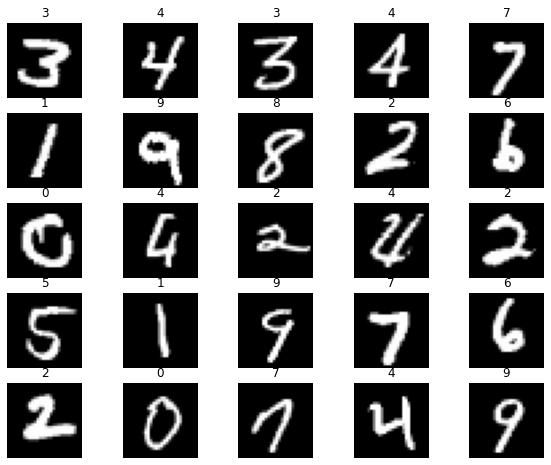

In [4]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
from torch.utils.data import DataLoader

trainloader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1),

In [6]:
net = MetaPrior(layer_sizes=[784, 100, 10], code_dim=10)

lossf = nn.CrossEntropyLoss()
optim = torch.optim.Adam(net.parameters(), lr=0.001)

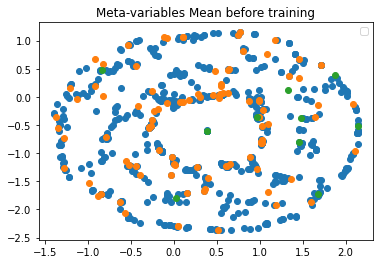

In [7]:
def plot_metaprior_tsne(net, train=True):
    show = True
    direct = './tsne'
    perplexity = 50
    lr = 500
    n_iter = 1000
    early_exaggeration = 12
    n_comp = 2

    # Define algorithm
    tsne = TSNE(n_components=n_comp, perplexity=perplexity, learning_rate=lr, n_iter=n_iter, early_exaggeration=early_exaggeration)

    # Fit on training data
#     print(torch.vstack(([m for m in net.code_mu])).shape)
    
    fitted = tsne.fit(torch.vstack(([m for m in net.code_mu])).detach().cpu().numpy())
#     print("Train set finished after {} iterations".format(fitted.n_iter))
    embedding = fitted.embedding_

#     print(embedding.shape)
    shapes = ((0, 784), (784, 884), (884, 894))
    for (s1, s2) in shapes:
        plt.scatter(embedding[s1:s2, 0], embedding[s1:s2, 1])

    plt.legend(('Layer{}'.format(i) for i in range(len(net.codes))))
    plt.title("Meta-variables Mean {} training".format("before" if train else "after"))
    plt.show()
    

plot_metaprior_tsne(net)

C:\Users\Phil\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")



Epoch [1/10] CE: 2.7789 KLZ: 0.2886


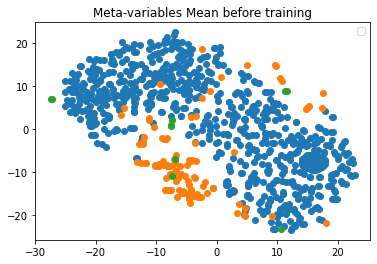


Epoch [2/10] CE: 2.3102 KLZ: 0.2062


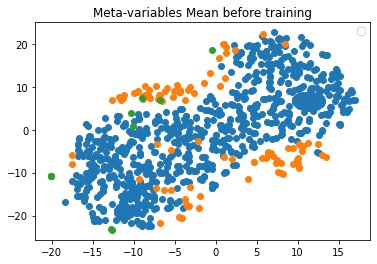


Epoch [3/10] CE: 2.3084 KLZ: 0.2244


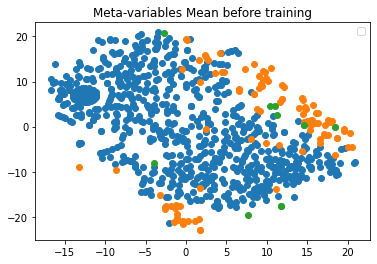


Epoch [4/10] CE: 2.3053 KLZ: 0.2719


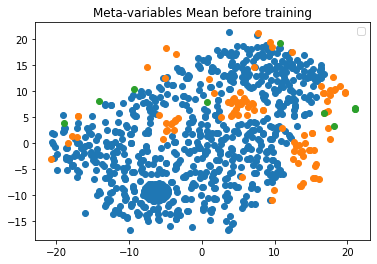


Epoch [5/10] CE: 2.3038 KLZ: 0.3414


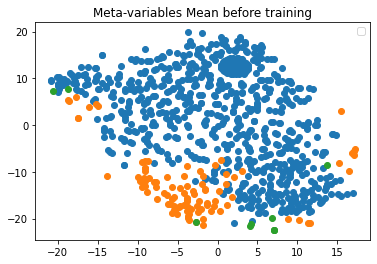


Epoch [6/10] CE: 2.3029 KLZ: 0.4892


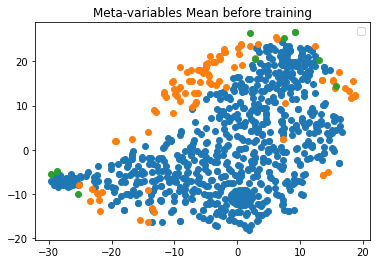


Epoch [7/10] CE: 2.3020 KLZ: 0.7718


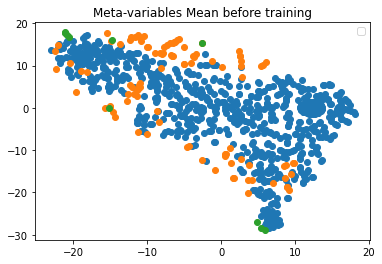


Epoch [8/10] CE: 2.3008 KLZ: 1.1741


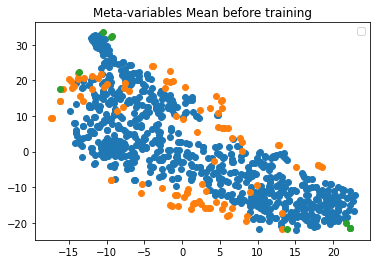


Epoch [9/10] CE: 2.2986 KLZ: 2.1780


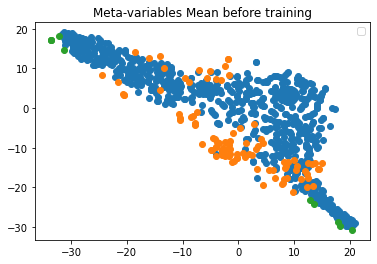


Epoch [10/10] CE: 2.2983 KLZ: 5.5996


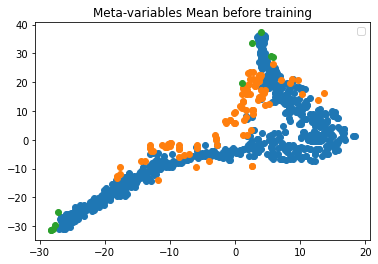

In [8]:

        
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    net.train()
    epoch_celoss = 0
    epoch_klz = 0
    epoch_acc = 0
    num_batches = 0
    
    for (images, labels) in tqdm(trainloader):
        # Clear grads
        optim.zero_grad()    
        
        # Get prediction
        preds = net(images.flatten(1))               
        
        # Build loss
        celoss = lossf(preds, labels)
        klz = net.kl_z_term()
        loss = celoss + 0.001 * klz
        
        # Perform step
        loss.backward()    
        optim.step()                

        epoch_celoss += celoss.item()
        epoch_klz += klz.item()
        num_batches += 1
        
    # Report loss, visualize tsne of meta-space
    net.eval()
    test_preds = net()
    
    print('Epoch [{}/{}] CE: {:.4f} KLZ: {:.4f}'.format(epoch + 1, num_epochs, epoch_celoss / num_batches, 
                                                        epoch_klz / num_batches))
    plot_metaprior_tsne(net)
